In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.linalg import circulant
from scipy.stats import norm
import seaborn as sns
from keras.datasets import mnist
from scipy.signal import fftconvolve

def BinaryRandomMatrix(S,M,p):
    r = np.random.rand(S,M)
    m = np.zeros((S,M))
    m[r<p] = 1.0
    return m

def MakeAffinities(params):
    pix = BinaryRandomMatrix(params['Num_tcell'],params['Num_sites'],params['pval_cell']) 
    palphax = (params['c'] + np.random.normal(0,params['sigma_cp'],(params['Num_treg'],params['Num_sites']) ) )* BinaryRandomMatrix(params['Num_treg'],params['Num_sites'],params['pval_treg']) 
    return pix, palphax

def MakeOverlaps(pix,palphax,vx):
    phi_reg_reg = (palphax*vx).dot(palphax.T)
    phi_cell_reg = (pix*vx).dot(palphax.T)
    rvals = pix.dot(vx)
    return phi_reg_reg, phi_cell_reg, rvals

def TrainNetwork(phi_reg_reg,phi_cell_reg,rvals):
    Num_treg = len(phi_reg_reg)
    Num_tcell = len(phi_cell_reg)
    Treg = cvx.Variable(Num_treg)
    G = np.vstack((-(phi_cell_reg.T/rvals).T,-np.eye(Num_treg)))
    h = np.hstack((-np.ones(Num_tcell),np.zeros(Num_treg)))
    constraints = [G@Treg <= h]
    obj = cvx.Minimize((1/2)*cvx.quad_form(Treg,phi_reg_reg))
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.ECOS,abstol=1e-9,feastol=1e-7,abstol_inacc=1e-5,feastol_inacc=1e-5,max_iters=5000,verbose=False)
    Tcell=constraints[0].dual_value[:Num_tcell]
    Treg=Treg.value
    return Tcell,Treg

# Binary affinities, iid

We start with Owen's code (cleaned up a bit), which samples binding probabilities independently for each cell-antigen pair:

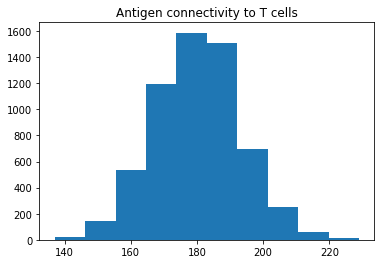

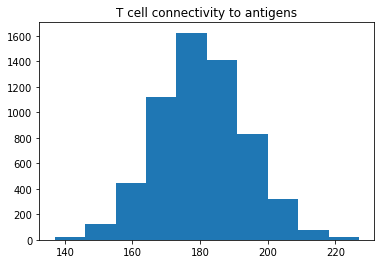

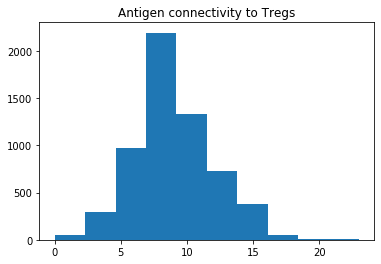

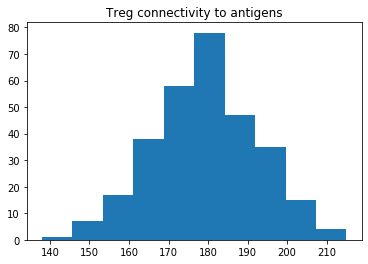

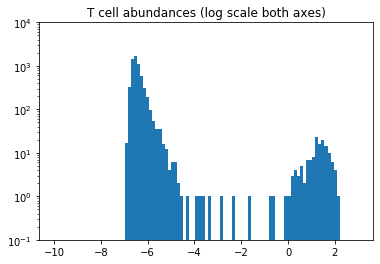

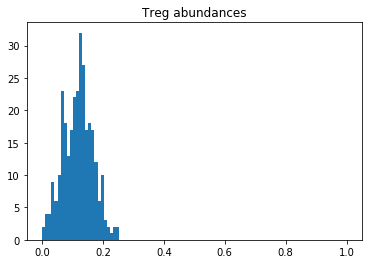

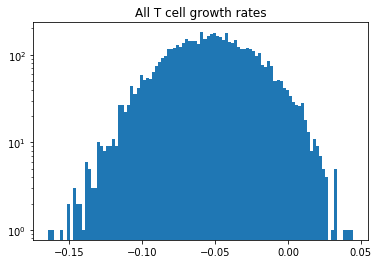

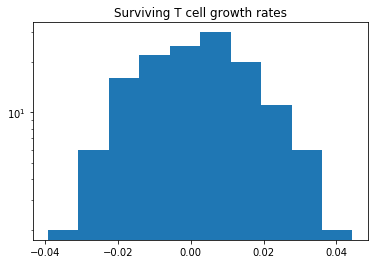

-----------INFECTION------------


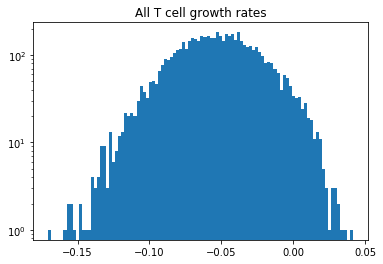

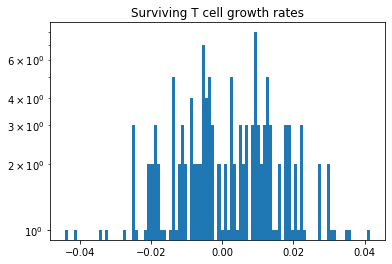

In [56]:
Num_path = 100
#declare simulation paramaters:
params={
#the number of Tregs
'Num_treg' : 300,
#the number of Tcells
'Num_tcell' : 6000,
#the number of sites
'Num_sites' : 6000,
#the Treg- antigen site binding strenth
'c' : 1.0,
#the varience in Treg-antigen binding around zero
'sigma_c' : 0.0,
#the varience in Treg-antigen binding around c
'sigma_cp' : 0.0,
#the binding
'pval_cell' : 0.03,
'pval_treg' : 0.03,
'max_v' : 1.0}

#Define antigen concentrations
vx = 0.5*params['max_v'] * np.ones(params['Num_sites']) #+ np.random.uniform(-max_v/2,max_v/2,Num_sites) 
vx[:Num_path] = 0

#generate a Treg-Tcell graph
#######################################
pix, palphax = MakeAffinities(params)

#now compute the r_{i} and \phi quantities
######################################################################
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)

####################################################################################
#compute the Treg steady state and active set of constraints
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Make lots of histograms
plt.hist( pix.sum( axis = 0) )
plt.gca().set_title('Antigen connectivity to T cells')
plt.show()
plt.hist( pix.sum( axis = 1) )
plt.gca().set_title('T cell connectivity to antigens')
plt.show()
plt.hist( palphax.sum( axis = 0) )
plt.gca().set_title('Antigen connectivity to Tregs')
plt.show()
plt.hist( palphax.sum( axis = 1) )
plt.gca().set_title('Treg connectivity to antigens')
plt.show()
plt.hist(np.log10(Tcell),bins=np.linspace(-10,3,100))
plt.gca().set_title('T cell abundances (log scale both axes)')
plt.gca().set_yscale('log')
plt.gca().set_ylim((0.1,10000))
plt.show()
plt.hist(Treg,bins=np.linspace(0,1,100))
plt.gca().set_title('Treg abundances')
plt.show()

#Randomly vary all the v_x values between 0 and max_v:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(len(vx))
vx[:Num_path] = 0
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_yscale('log')
plt.gca().set_title('All T cell growth rates')
plt.show()
out = out[Tcell>thresh]
plt.hist(1-out)
plt.gca().set_yscale('log')
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

print('-----------INFECTION------------')
#Randomly vary all the v_x values between 0 and max_v, including pathogens:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out,bins=100)
plt.gca().set_title('Surviving T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

# Binary affinities, fixed degree

This scheme fails to find the "$\rho$ point", because too many antigens fall in the Treg niche overlap. Let's try a different way of sampling the affinities. First, we'll choose the number of Tregs connected to each antigen from a narrow distribution, but leave everything else random:

In [65]:
def MakeAffinities_fixed_degree(params):
    pix = BinaryRandomMatrix(params['Num_tcell'],params['Num_sites'],params['pval_cell']) 
    palphax = np.zeros((params['Num_treg'],params['Num_sites']))
    degree = np.asarray(params['degree']+np.random.randn(params['Num_sites'])*params['sigma_degree'],dtype=int)
    for i in range(params['Num_sites']):
        palphax[:degree[i],i] = params['c']*np.ones(degree[i])+np.random.randn(degree[i])*params['sigma_c']
        np.random.shuffle(palphax[:,i])
    return pix, palphax

If we give all the antigens exactly the same connectivity to Tregs, and make all the binding affinities exactly the same, we get our desired result: all the T cells coexist, and the growth rates are totally insensitive to $v_x$. But if we add even a tiny amount of noise to either, competitive exclusion gets enforced, and we get some sensitivity to the $v_x$. It is small, though -- one percent noise in the degree and in the binding strength gives a proliferation rate of about a tenth of a percent of the basal rate.

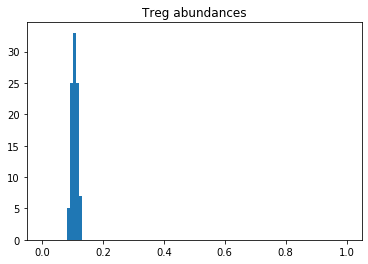

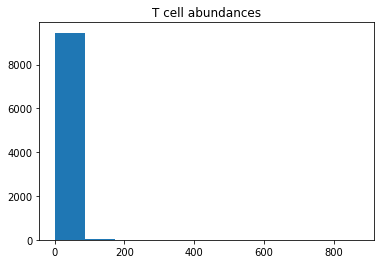

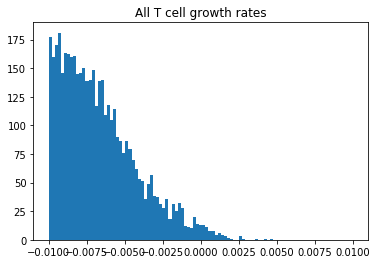

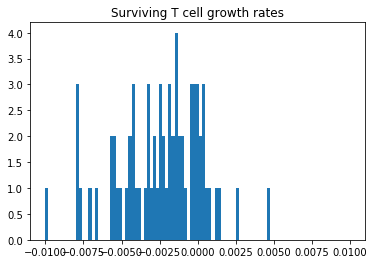

In [104]:
params['degree'] = 10
params['sigma_degree'] = 0.1
params['sigma_c'] = 0.01
pix, palphax = MakeAffinities_fixed_degree(params)
vx=(params['max_v']/2)*np.ones(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
plt.hist(Treg,bins=np.linspace(0,1,100))
plt.gca().set_title('Treg abundances')
plt.show()
plt.hist(Tcell)
plt.gca().set_title('T cell abundances')
plt.show()

#Randomly vary all the v_x values between 0 and max_v:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(len(vx))
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('All T cell growth rates')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

# Perfect Gaussian tiling

We can also try using an evenly tiled circulant matrix. This works extremely well:

In [119]:
def MakeAffinities_circulant(params):
    circ = circulant(norm.pdf(np.linspace(-params['Num_sites']/2,params['Num_sites']/2,params['Num_sites'])/params['niche_width']))
    pix = circ[np.linspace(0,params['Num_sites']-1,params['Num_tcell'],dtype=int),:]
    palphax = params['c']*circ[np.linspace(0,params['Num_sites']-1,params['Num_treg'],dtype=int),:]
    return pix, palphax

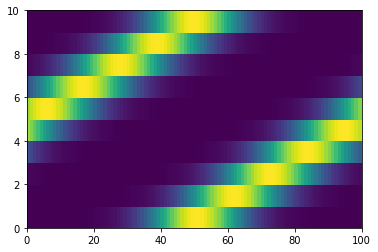

In [122]:
params_test = {}
params_test['niche_width'] = 10
params_test['Num_sites'] = 100
params_test['Num_tcell'] = 10
params_test['Num_treg'] = 10
params_test['c'] = 1
plt.pcolor(MakeAffinities_circulant(params_test)[0])
plt.show()

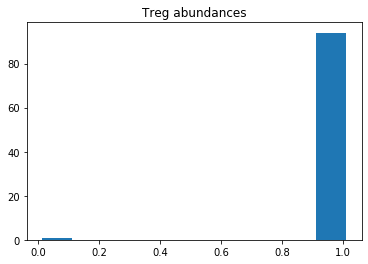

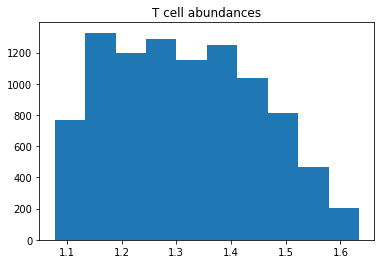

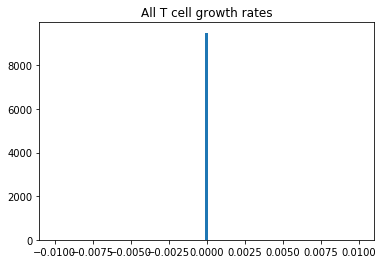

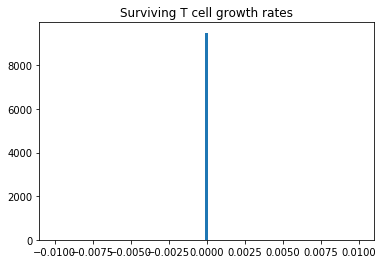

In [127]:
params['niche_width'] = params['Num_sites']/params['Num_treg']
pix, palphax = MakeAffinities_circulant(params)
vx = (params['max_v']/2)*np.ones(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
plt.hist(Treg)
plt.gca().set_title('Treg abundances')
plt.show()
plt.hist(Tcell)
plt.gca().set_title('T cell abundances')
plt.show()

#Randomly vary all the v_x values between 0 and max_v:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(len(vx))
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('All T cell growth rates')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

# Random Gaussian niche species

Or a random subsample of circulant matrix. In this case, a lot of Tregs go extinct, so we need to start with more. We get an extremely strange result, though, which is the combination of a lot of variability in Treg population size, but no sensitivity to $v_x$!

In [3]:
def MakeAffinities_circulant_rand(params):
    circ = circulant(norm.pdf(np.linspace(-params['Num_sites']/2,params['Num_sites']/2,params['Num_sites'])/params['niche_width'])/norm.pdf(0))
    Tcell_choice = np.random.choice(params['Num_sites'],size=params['Num_tcell'],replace=True)
    Treg_choice = np.random.choice(params['Num_sites'],size=params['Num_treg'],replace=True)
    pix = circ[Tcell_choice,:]
    palphax = params['c']*circ[Treg_choice,:]
    return pix, palphax

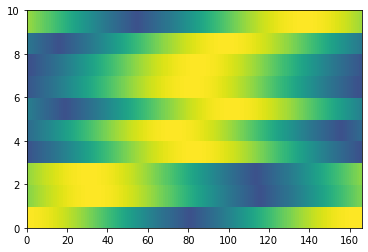

In [27]:
params_test = {}
params_test['niche_width'] = 50
params_test['Num_sites'] = int(500/3)
params_test['Num_tcell'] = 10
params_test['Num_treg'] = 10
params_test['c'] = 1
plt.pcolor(MakeAffinities_circulant_rand(params_test)[0],vmin=0,vmax=1)
plt.show()

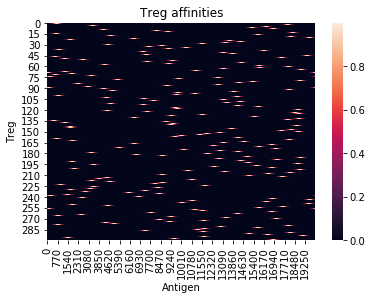

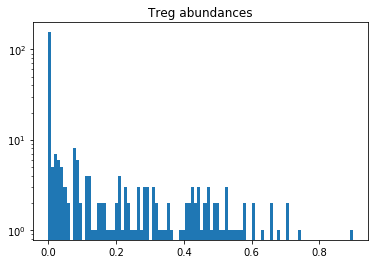

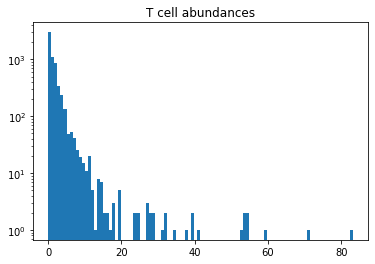

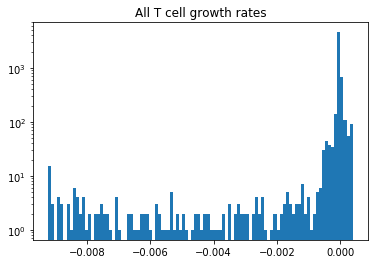

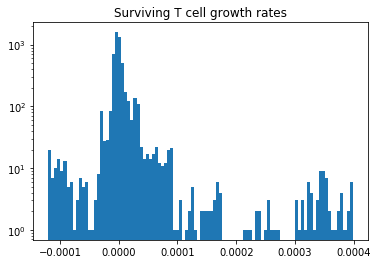

-----------INFECTION------------


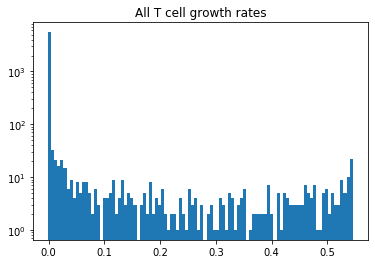

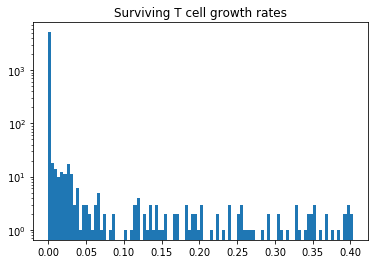

In [4]:
Num_path = 1000
params = {}
params['Num_treg'] = 300
params['Num_tcell'] = 6000
params['Num_sites'] = 20000
params['c'] = 1
params['max_v'] = 1
params['niche_width'] = 3*params['Num_sites']/params['Num_treg']
pix, palphax = MakeAffinities_circulant_rand(params)
sns.heatmap(palphax)
plt.gca().set_title('Treg affinities')
plt.gca().set_xlabel('Antigen')
plt.gca().set_ylabel('Treg')
plt.show()

vx = params['max_v']*np.random.rand(params['Num_sites'])
#vx = (params['max_v']/2)*np.ones(params['Num_sites'])
vx[:Num_path] = 0

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
plt.hist(Treg,bins=100)
plt.gca().set_title('Treg abundances')
plt.gca().set_yscale('log')
plt.show()
plt.hist(Tcell,bins=100)
plt.gca().set_title('T cell abundances')
plt.gca().set_yscale('log')
plt.show()

#Randomly vary all the v_x values between 0 and max_v, keeping pathogens at 0:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(params['Num_sites'])
vx[:Num_path] = 0
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out,bins=100)
plt.gca().set_title('Surviving T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

print('-----------INFECTION------------')
#Randomly vary all the v_x values between 0 and max_v, including pathogens:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out,bins=100)
plt.gca().set_title('Surviving T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

The last two plots above include the addition of 100 pathogen antigens that are statistically identical to self antigens. We can also go to the other extreme, and add pathogen antigens that are guaranteed _a priori_ not to bind to any Tregs. I will sample the T cell binding affinities randomly from the original matrix:

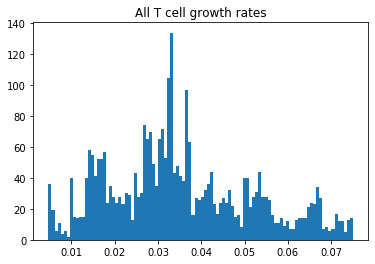

In [144]:
vx = params['max_v']*np.random.rand(params['Num_sites']+Num_path)
vx[:Num_path] = 0 #Get rid of statistically identical pathogens from previous part
pix_new = pix[:,np.random.choice(np.arange(Num_path,params['Num_sites']),size=Num_path,replace=True)]
palphax_new = np.zeros((len(palphax),Num_path))
pix = np.hstack((pix,pix_new))
palphax = np.hstack((palphax,palphax_new))
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.show()

# Theory

The sensitivity of the T cell proliferation rate to changes in antigen concentration is

\begin{align}
\frac{\partial g_i}{\partial v_x} = p_{ix}(\rho - \sum_\alpha p_{\alpha x} w_\alpha).
\end{align}

To make the system insensitive to changes in $v_x$, the term in parentheses needs to vanish. The simplest way to do this for all $v_x$ is to just minimize the sum of the squared term in parentheses over all $x$. But we can achieve the same result by minimizing the magnitude of the vector $\sum_\alpha p_{\alpha x} w_\alpha$, subject to the constraint that $\sum_\alpha p_{\alpha x} w_\alpha \geq \rho$ for all $x$. As long as the parameters have been chosen in such a way that the solution $\partial g_i/\partial v_x = 0$ exists for all $x$ simultaneously, it doesn't matter what metric we use for the minimization. Just in case we can't actually achieve the result for all $x$, we want to at least make sure we get to this point for antigens with high $v_x$. This leads to the following optimization problem:

Minimize
\begin{align}
\sum_{x\alpha\beta} v_x p_{\alpha x}p_{\beta x} w_\alpha w_\beta
\end{align}

subject to
\begin{align}
\sum_\alpha p_{\alpha x}w_\alpha \geq \rho.
\end{align}

Finally, we can aggregate these constraints in a clever way as well, by requiring that 
\begin{align}
\sum_{x\alpha} q_x p_{\alpha x}w_\alpha \geq \rho\sum_x q_x.
\end{align}
for all positive vectors $q_x$. In the actual problem, $q_x = v_x p_{ix}$, and the constraints are best enforced when there is the highest possible diversity of T cells.

# ML application

## Case 1: differential privacy

Let each entry in a database be indexed by $x$. Now make random combinations of features $p_{ix}$ and $p_{\alpha x}$, one indexed by $i$ and the other indexed by $\alpha$. Finally, compute the kernels $r_i^{-1}\phi_{i\alpha} = (\sum_x p_{ix} p_{\alpha x})/\sum_x p_{ix}$ and $\phi_{\alpha\beta} = \sum_x p_{\alpha x} p_{\beta x}$.  If the size of the database is much larger than the dimension of both feature spaces, it is impossible to reconstruct the actual database entries from these quantities, so they can be securely shared. Especially if the mapping to the feature spaces is also private. 

Now train the weights according to our algorithm. As the database grows, keep sending the analyst the updated $r_i^{-1} \phi_{i\alpha}$. If outliers start showing up, $\rho-\sum_\alpha w_\alpha r_i^{-1} \phi_{i\alpha}$ will become positive. They should be alarming if any of these quantities start becoming a significant fraction of $\rho$. From the list of $i$'s that are giving positive signals, the database should be able to reconstruct the set of original features that are causing the problem.

## Case 2: authentication

Now let $v_x$ be the vector representation of a single database item, such as a user's history. Let $p_{\alpha x}$ and $p_{i x}$ be mappings into low-dimensional feature spaces, and construct the two kernels $r_i^{-1}\phi_{i\alpha} = (\sum_x v_x p_{ix} p_{\alpha x})/\sum_x v_x p_{ix}$ and $\phi_{\alpha\beta} = \sum_x v_x p_{\alpha x} p_{\beta x}$. Again, these kernels do not reveal any details of the user's history. 

Now train the weights. Using the $w_\alpha$, one can now test the identity of agents who claim to be this user. 

# Try on MNIST

- Make random convolutions for $p_{\alpha x}$ and $p_{ix}$, using just one class
- Feed into functions defined above to get kernels
- Train
- Update with more examples from same class, or from different class

What to compare to? I guess trying to judge based on comparison between new image and average of all original images.

In [33]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
self = list(X_test[Y_test==0])
for label in [1,2,3,4]:
    self = self+list(X_test[Y_test==label])
self=np.asarray(self)
foreign = X_test[Y_test==5]

In [35]:
params = {}
params['Num_treg'] = 100
params['Num_tcell'] = 1000
params['Num_sites'] = 3000

k = 0
size = 28*28
palphax = np.zeros((params['Num_treg'],params['Num_sites']))
pix = np.zeros((params['Num_tcell'],params['Num_sites']))
for k in range(params['Num_treg']):
    con_rand = np.random.rand(4,4)-0.5
    con_rand = con_rand_al[np.newaxis,:,:]
    palphax[k,:] = fftconvolve(self[:params['Num_sites']],con_rand_al).sum(axis=1).sum(axis=1)/size
for k in range(params['Num_tcell']):
    con_rand = np.random.rand(4,4)-0.5
    con_rand = con_rand_al[np.newaxis,:,:]
    pix[k,:] = fftconvolve(self[:params['Num_sites']],con_rand_al).sum(axis=1).sum(axis=1)/size

In [28]:
vx = np.ones(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
plt.hist(Treg,bins=100)
plt.gca().set_title('Treg abundances')
plt.gca().set_yscale('log')
plt.show()
plt.hist(Tcell,bins=100)
plt.gca().set_title('T cell abundances')
plt.gca().set_yscale('log')
plt.show()

#Randomly vary all the v_x values between 0 and max_v, keeping pathogens at 0:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(params['Num_sites'])
vx[:Num_path] = 0
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out,bins=100)
plt.gca().set_title('Surviving T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

print('-----------INFECTION------------')
#Randomly vary all the v_x values between 0 and max_v, including pathogens:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out,bins=100)
plt.gca().set_title('Surviving T cell growth rates')
plt.gca().set_yscale('log')
plt.show()

20